In [11]:
# Importar las bibliotecas
import pandas as pd
from google.colab import drive
# Montar Google Drive
drive.mount('/content/drive')
# Ruta donde se guardará el archivo en Google Drive
ruta_archivo = '/content/drive/My Drive/Tesis/data analisis.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
# ============================
# Librerías
# ============================
import math
import pandas as pd
import numpy as np

# ============================
# Visualización
# ============================
import matplotlib.pyplot as plt
import seaborn as sns

# ============================
# Estadística
# ============================
from scipy.stats import spearmanr

# ============================
# Machine Learning
# ============================
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

## **PREPROCESAMIENTO DE LA DATA**

In [23]:

# Equipos según la región
Equipos_sin_altura = [
    '9 de Octubre FC', 'Barcelona SC', 'CS Emelec', 'Delfin SC',
    'Fuerza Amarilla SC', 'Guayaquil City FC', 'LDU Portoviejo',
    'Manta FC', 'Orense SC'
]

Equipos_con_altura = [
    'CD Independiente del Valle', 'LDU de Quito', 'CD El Nacional',
    'Libertad FC', 'Imbabura SC', 'CD Macara', 'SD Aucas',
    'Mushuc Runa SC', 'CD Universidad Catolica', 'Cumbaya FC',
    'CD Tecnico Universitario', 'CD Cuenca', 'Gualaceo SC',
    'CD Olmedo', 'CD America Quito'
]

# Carga del dataset
df = pd.read_excel(ruta_archivo)
df['Saldo_Goles'] = df['GF'] - df['GC']


# 4. Codificación de variables categóricas
encoder = OneHotEncoder(sparse_output=False)
formaciones_oponente_encoded = encoder.fit_transform(df[['Formación Visitante']])
formaciones_oponente_df = pd.DataFrame(
    formaciones_oponente_encoded, columns=encoder.categories_[0]
)

resultados_df = pd.get_dummies(df['Resultado'], prefix='Resultado')

# Unir los datos preprocesados
df = pd.concat([df, formaciones_oponente_df, resultados_df], axis=1)

# Clasificación de partidos según la región
def clasificar_partido(row):
    local_en_altura = row['Local'] in Equipos_con_altura
    visitante_en_altura = row['Visitante'] in Equipos_con_altura
    local_en_costa = row['Local'] in Equipos_sin_altura
    visitante_en_costa = row['Visitante'] in Equipos_sin_altura

    if local_en_altura and visitante_en_altura:
        return 'Altura vs Altura'
    elif local_en_costa and visitante_en_costa:
        return 'Costa vs Costa'
    elif local_en_altura and visitante_en_costa:
        return 'Altura vs Costa'
    elif local_en_costa and visitante_en_altura:
        return 'Costa vs Altura'

# Aplicar la clasificación al DataFrame
df['clasificacion_del_partido'] = df.apply(clasificar_partido, axis=1)

# División del DataFrame en subconjuntos
df_sierra_costa = df[df['clasificacion_del_partido'] == 'Altura vs Costa']
df_costa_sierra = df[df['clasificacion_del_partido'] == 'Costa vs Altura']
df_sierra_sierra = df[df['clasificacion_del_partido'] == 'Altura vs Altura']
df_costa_costa = df[df['clasificacion_del_partido'] == 'Costa vs Costa']


## **ANALISIS DESCRIPTIVO DE LOS DATOS**

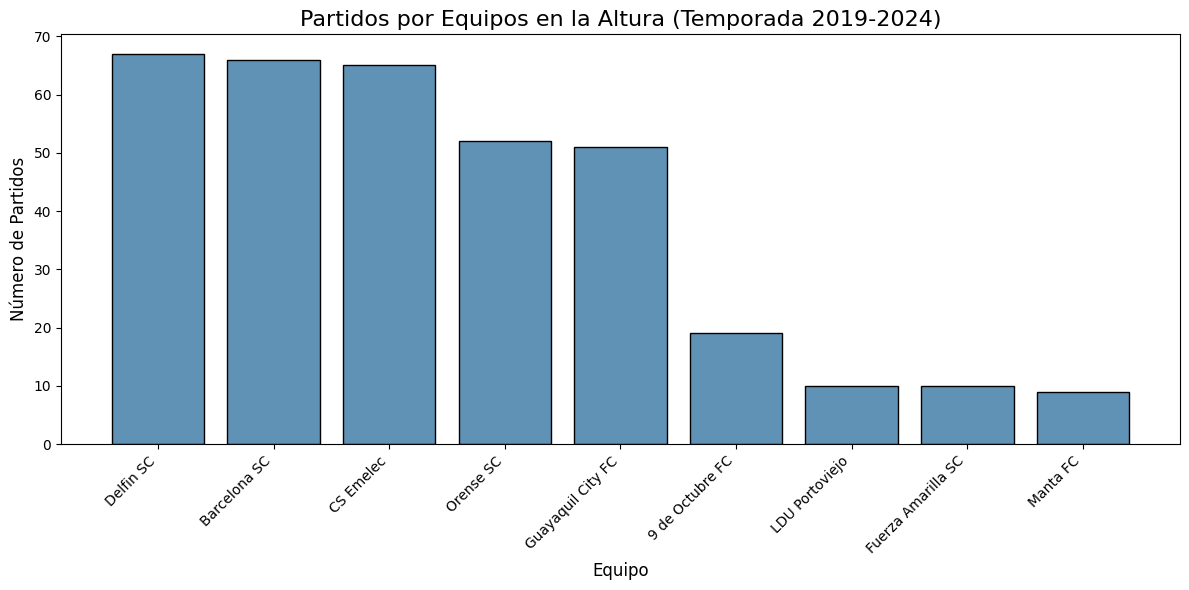

In [24]:
# Obtener los conteos de los adversarios
conteo_adversarios = df_sierra_costa["Visitante"].value_counts()

# Crear el gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(conteo_adversarios.index, conteo_adversarios.values, color='#6092b6', edgecolor='black')

# Personalizar el gráfico
plt.title('Partidos por Equipos en la Altura (Temporada 2019-2024)', fontsize=16)
plt.xlabel('Equipo', fontsize=12)
plt.ylabel('Número de Partidos', fontsize=12)
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para mejor visibilidad
plt.grid(axis='y', linestyle='--', alpha=0.7)
# Mostrar el gráfico
plt.grid(False)
plt.tight_layout()
plt.show()

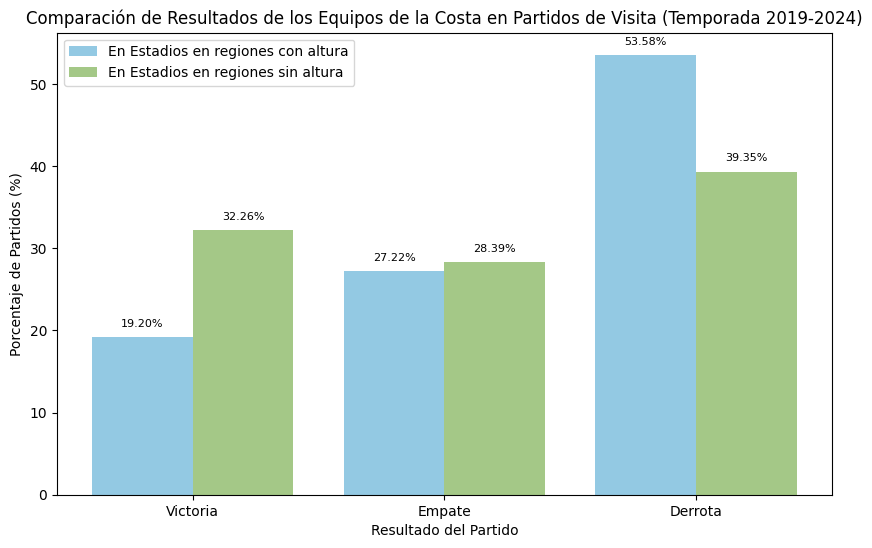

In [25]:

# Contar las ocurrencias de cada resultado y calcular porcentajes
def calcular_porcentajes(df):
    counts = df['Resultado'].value_counts(normalize=True).reindex(['V', 'E', 'D'], fill_value=0) * 100
    return counts

# Configuración del gráfico
resultados = ['Victoria', 'Empate', 'Derrota']
x = np.arange(len(resultados))
width = 0.4  # Ancho de las barras (Aumentado para mayor visibilidad)

fig, ax = plt.subplots(figsize=(10, 6))

# Calcular porcentajes para cada categoría
sierra_costa_pct = calcular_porcentajes(df_sierra_costa)
costa_sierra_pct = calcular_porcentajes(df_costa_sierra)
sierra_sierra_pct = calcular_porcentajes(df_sierra_sierra)
costa_costa_pct = calcular_porcentajes(df_costa_costa)

# Graficar las barras con porcentajes
bars1 = ax.bar(x - width / 2, sierra_costa_pct, width, label="En Estadios en regiones con altura", color="#93c9e3")
bars2 = ax.bar(x + width / 2, costa_costa_pct, width, label="En Estadios en regiones sin altura", color="#a4c887")

# Función para agregar etiquetas de porcentaje sobre las barras
def agregar_porcentajes(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f'{height:.2f}%',
                ha='center', va='bottom', fontsize=8, fontweight='normal')

# Agregar porcentajes a cada grupo de barras
agregar_porcentajes(bars1)
agregar_porcentajes(bars2)

# Etiquetas y título
ax.set_xlabel("Resultado del Partido")
ax.set_ylabel("Porcentaje de Partidos (%)")
ax.set_title("Comparación de Resultados de los Equipos de la Costa en Partidos de Visita (Temporada 2019-2024)")
ax.set_xticks(x)
ax.set_xticklabels(resultados)
ax.legend()

# Guardar y mostrar el gráfico
plt.savefig('porcentaje_resultados.png')
plt.show()


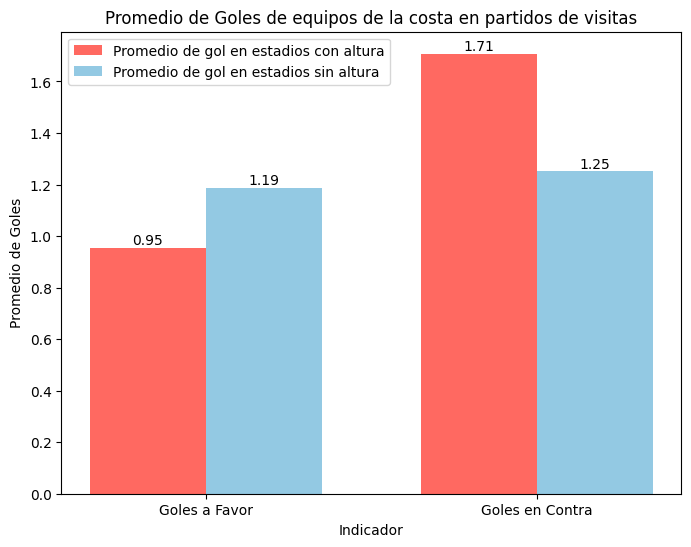

In [26]:
# Datos: Promedios de GF y GC
gf_sierra_costa = df_sierra_costa["GF"].mean()
gc_sierra_costa = df_sierra_costa["GC"].mean()
gf_costa_costa = df_costa_costa["GF"].mean()
gc_costa_costa = df_costa_costa["GC"].mean()

# Configuración de datos
labels = ['Goles a Favor', 'Goles en Contra']
height_sierra_costa = [gf_sierra_costa, gc_sierra_costa]
height_costa_costa = [gf_costa_costa, gc_costa_costa]

# Posiciones y ancho de las barras
x = np.arange(len(labels))
width = 0.35

# Crear el gráfico
fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, height_sierra_costa, width, label='Promedio de gol en estadios con altura', color="#FF6961")
bars2 = ax.bar(x + width/2, height_costa_costa, width, label='Promedio de gol en estadios sin altura', color="#93c9e3")

# Añadir etiquetas sobre las barras
def agregar_etiquetas(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom', fontsize=10)

agregar_etiquetas(bars1)
agregar_etiquetas(bars2)

# Configuración de ejes y leyenda
ax.set_xlabel('Indicador')
ax.set_ylabel('Promedio de Goles')
ax.set_title('Promedio de Goles de equipos de la costa en partidos de visitas')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Mostrar el gráfico
plt.show()


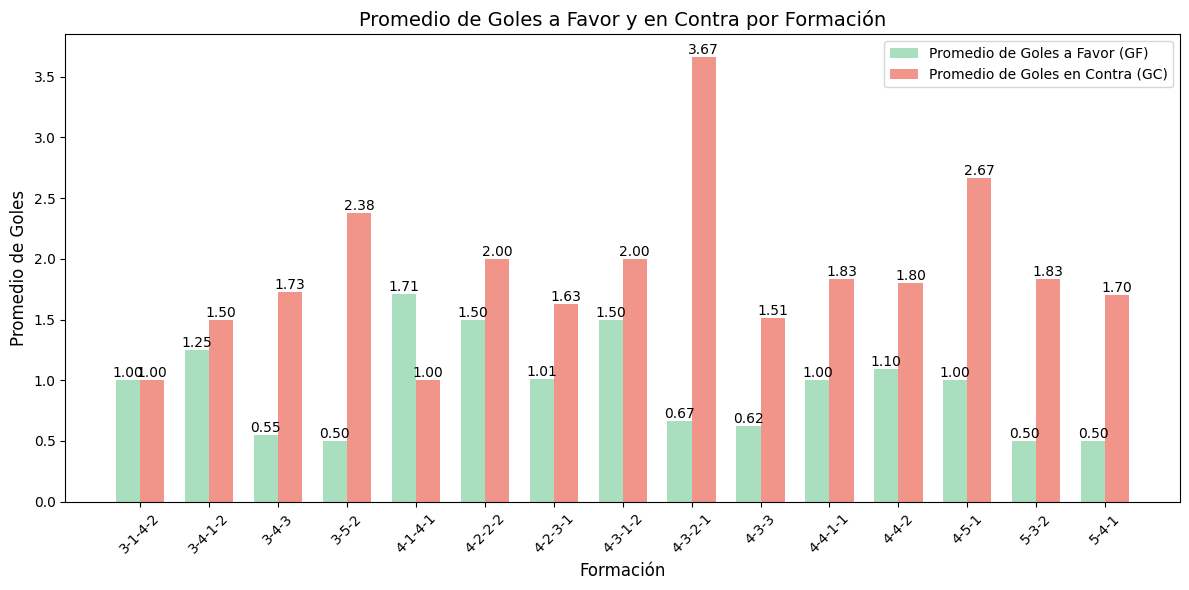

In [27]:
# 1. Agrupar los datos por formación y calcular el promedio de GF y GC
df_grouped = df_sierra_costa.groupby('Formación Visitante').agg({
    'GF': 'mean',   # Promedio de goles a favor
    'GC': 'mean'    # Promedio de goles en contra
}).reset_index()

# 2. Configuración del gráfico
x = np.arange(len(df_grouped['Formación Visitante']))  # Posiciones en el eje x
width = 0.35  # Ancho de las barras

fig, ax = plt.subplots(figsize=(12, 6))

# 3. Barras agrupadas para GF y GC
bars1 = ax.bar(x - width/2, df_grouped['GF'], width, label='Promedio de Goles a Favor (GF)', color="#a9dfbf")
bars2 = ax.bar(x + width/2, df_grouped['GC'], width, label='Promedio de Goles en Contra (GC)', color="#f1948a")

# 4. Función para agregar etiquetas sobre las barras
def agregar_etiquetas(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
                ha='center', va='bottom', fontsize=10)

# Añadir etiquetas a cada barra
agregar_etiquetas(bars1)
agregar_etiquetas(bars2)

# 5. Configuración de ejes y leyenda
ax.set_xlabel('Formación', fontsize=12)
ax.set_ylabel('Promedio de Goles', fontsize=12)
ax.set_title('Promedio de Goles a Favor y en Contra por Formación', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(df_grouped['Formación Visitante'], rotation=45)
ax.legend()

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()

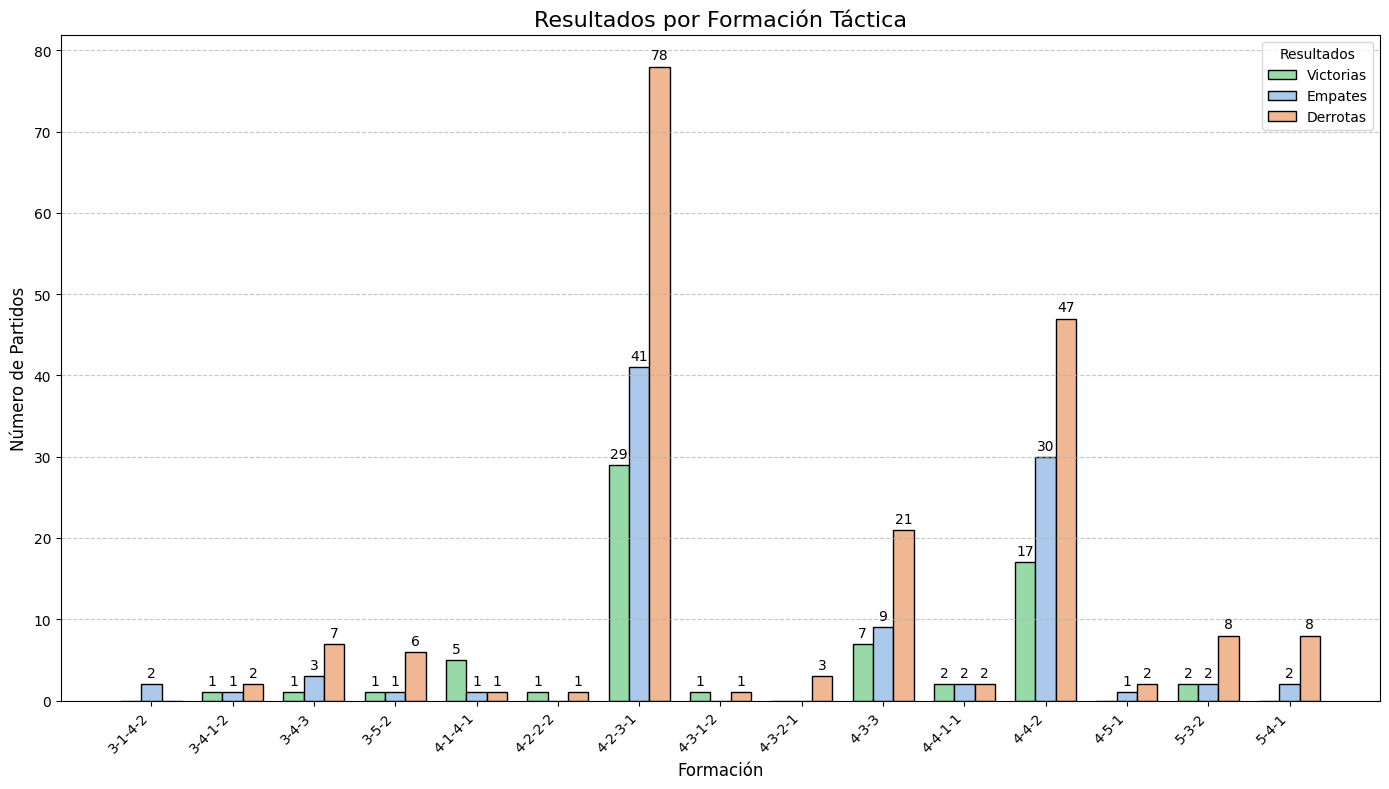

In [28]:
# Agrupar por formación táctica y resultado, y contar los partidos
resultados_por_formacion = df_sierra_costa.groupby(['Formación Visitante', 'Resultado']).size().unstack(fill_value=0)

# Configuración del gráfico
x = np.arange(len(resultados_por_formacion.index))  # Posiciones en el eje X
width = 0.25  # Ancho de las barras

plt.figure(figsize=(14, 8))

# Crear las barras agrupadas
bars_victorias = plt.bar(x - width, resultados_por_formacion['V'], width, label='Victorias', color='#98daa7', edgecolor='black')
bars_empates = plt.bar(x, resultados_por_formacion['E'], width, label='Empates', color='#abc9ea', edgecolor='black')
bars_derrotas = plt.bar(x + width, resultados_por_formacion['D'], width, label='Derrotas', color='#efb792', edgecolor='black')

# Agregar los valores encima de las barras
for bars in [bars_victorias, bars_empates, bars_derrotas]:
    for bar in bars:
        yval = bar.get_height()
        if yval > 0:
            plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.5, f'{int(yval)}', ha='center', va='bottom', fontsize=10)

# Personalizar el gráfico
plt.title('Resultados por Formación Táctica', fontsize=16)
plt.xlabel('Formación', fontsize=12)
plt.ylabel('Número de Partidos', fontsize=12)
plt.xticks(x, resultados_por_formacion.index, rotation=45, ha='right')  # Etiquetas del eje X
plt.legend(title='Resultados', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()

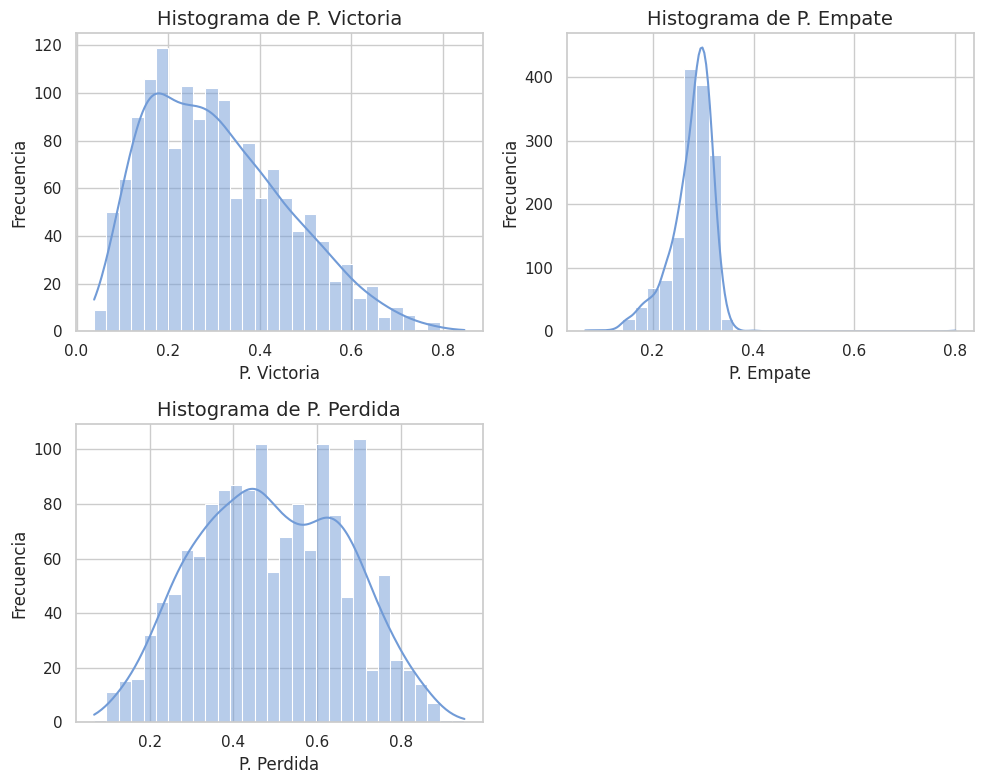

In [29]:
# Configurar el estilo de los gráficos (opcional)
sns.set(style="whitegrid")

# Lista de variables que deseas graficar
variables = ['P. Victoria', 'P. Empate','P. Perdida']  # Reemplaza con los nombres de tus columnas

# Determinar el número de variables
num_vars = len(variables)

# Configurar la cuadrícula de subplots (ajusta 'num_cols' según prefieras)
num_cols = 2
num_rows = math.ceil(num_vars / num_cols)

# Crear una figura con subplots
plt.figure(figsize=(5 * num_cols, 4 * num_rows))

for i, variable in enumerate(variables, 1):
    # Verificar que la variable existe en el DataFrame
    if variable in df.columns:
        plt.subplot(num_rows, num_cols, i)
        sns.histplot(df[variable].dropna(), bins=30, kde=True, color='#719bd7')
        plt.title(f'Histograma de {variable}', fontsize=14)
        plt.xlabel(variable, fontsize=12)
        plt.ylabel('Frecuencia', fontsize=12)
    else:
        print(f'La variable "{variable}" no existe en el DataFrame.')

# Ajustar el espacio entre subplots
plt.tight_layout()
plt.show()

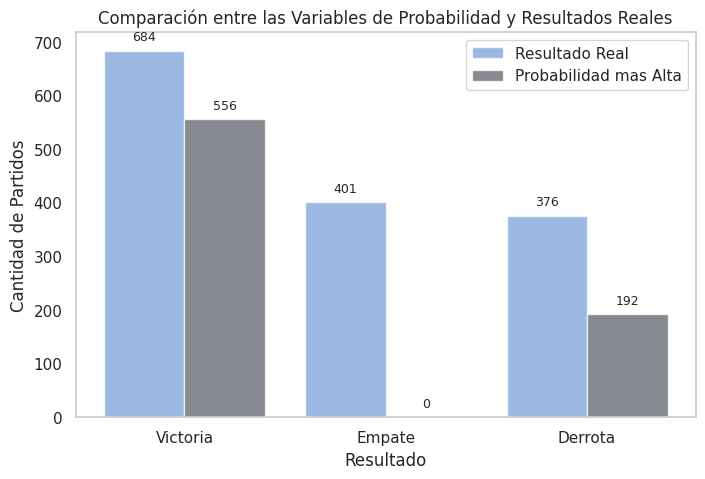

In [30]:
# Categorías posibles
categorias_posibles = ['D', 'E', 'V']

df['Max_Prob'] = df[['P. Victoria', 'P. Empate', 'P. Perdida']].idxmax(axis=1)
df['Max_Prob'] = df['Max_Prob'].map({'P. Victoria': 'V', 'P. Empate': 'E', 'P. Perdida': 'D'})
conteo_categorias = df[df['Resultado'] == df['Max_Prob']]['Resultado'].value_counts().reindex(categorias_posibles, fill_value=0)

# Contar total de cada clase en los datos reales
total_categorias = df['Resultado'].value_counts()

# Calcular porcentaje de aciertos por categoría
porcentaje_aciertos = (conteo_categorias / total_categorias) * 100

# Mostrar resultados
resultado_df = pd.DataFrame({
    'Total Real': total_categorias,
    'Aciertos': conteo_categorias.fillna(0).astype(int),
    'Porcentaje Aciertos': porcentaje_aciertos.fillna(0).round(2)
})

# Datos
categorias = ['Victoria', 'Empate', 'Derrota']
total_real = total_categorias.tolist()
aciertos = conteo_categorias.tolist()

# Crear gráfico de barras
x = np.arange(len(categorias))  # Posición en el eje X
width = 0.4  # Ancho de barras

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, total_real, width, label='Resultado Real', color='#719bd7', alpha=0.7)
bars2 = ax.bar(x + width/2, aciertos, width, label='Probabilidad mas Alta', color='#535961', alpha=0.7)

# Desactivar las líneas de fondo
ax.grid(False)

# Etiquetas y título
ax.set_xlabel('Resultado')
ax.set_ylabel('Cantidad de Partidos')
ax.set_title('Comparación entre las Variables de Probabilidad y Resultados Reales')
ax.set_xticks(x)
ax.set_xticklabels(categorias)
ax.legend()

# Mostrar porcentaje sobre cada barra
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{int(height)}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # Desplazamiento hacia arriba
                    textcoords="offset points",
                    ha='center', va='bottom',fontsize=9)

plt.show()

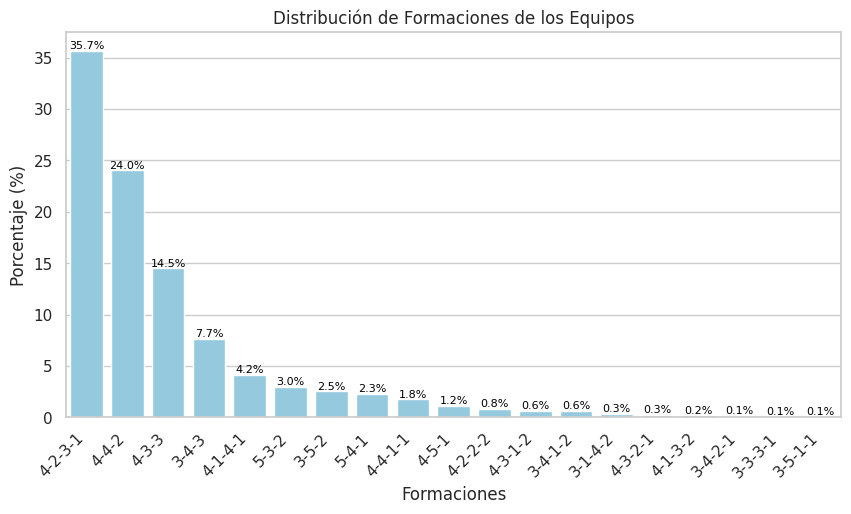

In [31]:
#data
df = pd.read_excel(ruta_archivo)
# Contar la frecuencia de cada formación
formacion_counts = df['Formación Visitante'].value_counts()

# Calcular el porcentaje
total = formacion_counts.sum()
formacion_percent = (formacion_counts / total) * 100  # Convertir a porcentaje

# Configurar la figura
plt.figure(figsize=(10, 5))
#ax = sns.barplot(x=formacion_percent.index, y=formacion_percent.values, palette='#87CEEB')
ax = sns.barplot(x=formacion_percent.index, y=formacion_percent.values, color='#87CEEB')  # Celeste claro


# Agregar valores en porcentaje sobre las barras con letras más pequeñas
for p in ax.patches:
    ax.annotate(f'{p.get_height():.1f}%',  # Formato con un decimal
                (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=8, color='black')  # Reducido fontsize=8

# Personalizar etiquetas y título
plt.xticks(rotation=45, ha='right')  # Rotar etiquetas para mejor visibilidad
plt.xlabel('Formaciones')
plt.ylabel('Porcentaje (%)')
plt.title('Distribución de Formaciones de los Equipos')

# Mostrar el gráfico
plt.show()


In [32]:
# Lista de formaciones utilizadas
formaciones = df_sierra_costa["Formación Visitante"].unique()

# Crear una lista para almacenar resultados
resultados = []

for formacion in formaciones:
    subset = df_sierra_costa[df_sierra_costa["Formación Visitante"] == formacion]  # Filtrar partidos con esta formación

    # Calcular correlación de Spearman
    corr_resultado_gf, p_gf = spearmanr(subset["Resultado"], subset["GF"])
    corr_resultado_gc, p_gc = spearmanr(subset["Resultado"], subset["GC"])

    # Calcular varianza y desviación estándar
    varianza_gf = subset["GF"].var()  # Varianza de goles a favor
    desviacion_gf = subset["GF"].std()  # Desviación estándar de goles a favor
    varianza_gc = subset["GC"].var()  # Varianza de goles en contra
    desviacion_gc = subset["GC"].std()  # Desviación estándar de goles en contra

    # Calcular promedios
    promedio_gf = subset["GF"].mean()  # Promedio de goles a favor
    promedio_gc = subset["GC"].mean()  # Promedio de goles en contra

    # Calcular conteo total de goles
    total_gf = subset["GF"].sum()  # Total de goles a favor
    total_gc = subset["GC"].sum()  # Total de goles en contra

    # Calcular promedio general (goles a favor + goles en contra) por formación
    promedio_general = (total_gf - total_gc) / len(subset) if len(subset) > 0 else 0  # Promedio general de goles por partido

    # Guardar resultados en una lista
    resultados.append([formacion, corr_resultado_gf, p_gf, corr_resultado_gc, p_gc, len(subset),
                       varianza_gf, desviacion_gf, varianza_gc, desviacion_gc,
                       promedio_gf, promedio_gc, total_gf, total_gc, promedio_general])

# Convertir a DataFrame
df_corr = pd.DataFrame(resultados, columns=["Formación", "Correlación Resultado-GF", "p-value GF",
                                             "Correlación Resultado-GC", "p-value GC", "N",
                                             "Varianza GF", "Desviación GF", "Varianza GC", "Desviación GC",
                                             "Promedio GF", "Promedio GC", "Total GF", "Total GC", "Promedio General"])

# Redondear los resultados a 3 decimales
df_corr = df_corr.round(3)

# Ordenar por formación
df_corr = df_corr.sort_values(by="Formación")

#Ordenar Columnas
ordenar_c = ['Formación','N', 'Total GF','Promedio GF','Varianza GF', 'Desviación GF','Correlación Resultado-GF', 'p-value GF', 'Total GC', 'Promedio GC', 'Varianza GC','Desviación GC', 'Correlación Resultado-GC', 'p-value GC','Promedio General' ]
df_corr = df_corr[ordenar_c]
# Mostrar la tabla
df_corr

<ipython-input-32-5ef66d5605a5>:11: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_resultado_gf, p_gf = spearmanr(subset["Resultado"], subset["GF"])
<ipython-input-32-5ef66d5605a5>:12: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr_resultado_gc, p_gc = spearmanr(subset["Resultado"], subset["GC"])


,Formación,N,Total GF,Promedio GF,Varianza GF,Desviación GF,Correlación Resultado-GF,p-value GF,Total GC,Promedio GC,Varianza GC,Desviación GC,Correlación Resultado-GC,p-value GC,Promedio General
13,3-1-4-2,2,2,1.000,0.000,0.000,NaN,NaN,2,1.000,0.000,0.000,NaN,NaN,0.000
2,3-4-1-2,4,5,1.250,2.250,1.500,1.000,0.000,6,1.500,0.333,0.577,0.943,0.057,-0.250
6,3-4-3,11,6,0.545,0.473,0.688,0.508,0.111,19,1.727,1.218,1.104,-0.708,0.015,-1.182
12,3-5-2,8,4,0.500,0.571,0.756,0.819,0.013,19,2.375,1.125,1.061,-0.776,0.023,-1.875
8,4-1-4-1,7,12,1.714,1.238,1.113,0.687,0.088,7,1.000,0.667,0.816,-0.118,0.801,0.714
5,4-2-2-2,2,3,1.500,4.500,2.121,1.000,NaN,4,2.000,2.000,1.414,-1.000,NaN,-0.500
0,4-2-3-1,148,150,1.014,0.775,0.881,0.550,0.000,241,1.628,1.446,1.202,-0.665,0.000,-0.615
14,4-3-1-2,2,3,1.500,0.500,0.707,-1.000,NaN,4,2.000,8.000,2.828,-1.000,NaN,-0.500
10,4-3-2-1,3,2,0.667,0.333,0.577,NaN,NaN,11,3.667,0.333,0.577,NaN,NaN,-3.000
1,4-3-3,37,23,0.622,0.797,0.893,0.661,0.000,56,1.514,1.701,1.304,-0.723,0.000,-0.892


In [33]:
# Agrupar por formación táctica y resultado, y contar los partidos
resultados_por_formacion = df_sierra_costa.groupby(['Formación Visitante', 'Resultado']).size().unstack(fill_value=0)

# Calcular el total de partidos
resultados_por_formacion['Total Partidos'] = resultados_por_formacion['V'] + resultados_por_formacion['E'] + resultados_por_formacion['D']

# Calcular los porcentajes
resultados_por_formacion['Porc. D. (%)'] = (resultados_por_formacion['D'] / resultados_por_formacion['Total Partidos']) * 100
resultados_por_formacion['Porc. E. (%)'] = (resultados_por_formacion['E'] / resultados_por_formacion['Total Partidos']) * 100
resultados_por_formacion['Porc. V. (%)'] = (resultados_por_formacion['V'] / resultados_por_formacion['Total Partidos']) * 100

# Redondear los resultados a 2 decimales (opcional)
resultados_por_formacion = resultados_por_formacion.round({'% D': 2, '% E': 2, '% V': 2})

# Calcular el total general de partidos
total_general = resultados_por_formacion['Total Partidos'].sum()

# Calcular el porcentaje del total de partidos para cada formación
resultados_por_formacion['% del Total'] = (resultados_por_formacion['Total Partidos'] / total_general) * 100

# Redondear a 2 decimales (opcional)
resultados_por_formacion['Porc (%)del Total'] = resultados_por_formacion['% del Total'].round(2)

orden_columnas = ['V', 'Porc. V. (%)', 'E', 'Porc. E. (%)', 'D','Porc. D. (%)', 'Total Partidos', 'Porc (%)del Total']
resultados_por_formacion = resultados_por_formacion[orden_columnas]

# Mostrar resultados
resultados_por_formacion


Resultado,V,Porc. V. (%),E,Porc. E. (%),D,Porc. D. (%),Total Partidos,Porc (%)del Total
Formación Visitante,,,,,,,,
3-1-4-2,0,0.000000,2,100.000000,0,0.000000,2,0.57
3-4-1-2,1,25.000000,1,25.000000,2,50.000000,4,1.15
3-4-3,1,9.090909,3,27.272727,7,63.636364,11,3.15
3-5-2,1,12.500000,1,12.500000,6,75.000000,8,2.29
4-1-4-1,5,71.428571,1,14.285714,1,14.285714,7,2.01
4-2-2-2,1,50.000000,0,0.000000,1,50.000000,2,0.57
4-2-3-1,29,19.594595,41,27.702703,78,52.702703,148,42.41
4-3-1-2,1,50.000000,0,0.000000,1,50.000000,2,0.57
4-3-2-1,0,0.000000,0,0.000000,3,100.000000,3,0.86


In [34]:
# Calcular los puntos obtenidos
resultados_por_formacion['Puntos'] = (resultados_por_formacion['V'] * 3) + (resultados_por_formacion['E'] * 1)

# Mostrar el DataFrame con los nuevos cálculos
#print(resultados_por_formacion)

# Calcular la media de puntos por formación
resultados_por_formacion['Media Puntos'] = resultados_por_formacion['Puntos'] / resultados_por_formacion['Total Partidos']

resultados_por_formacion['Desviación Estándar'] = resultados_por_formacion[['D', 'E', 'V']].std(axis=1)

resultados_por_formacion['Efectividad'] = (resultados_por_formacion['Puntos'] / (resultados_por_formacion['Total Partidos'] * 3)) * 100

# Mostrar el DataFrame con los nuevos cálculos
resultados_por_formacion

Resultado,V,Porc. V. (%),E,Porc. E. (%),D,Porc. D. (%),Total Partidos,Porc (%)del Total,Puntos,Media Puntos,Desviación Estándar,Efectividad
Formación Visitante,,,,,,,,,,,,
3-1-4-2,0,0.000000,2,100.000000,0,0.000000,2,0.57,2,1.000000,1.154701,33.333333
3-4-1-2,1,25.000000,1,25.000000,2,50.000000,4,1.15,4,1.000000,0.577350,33.333333
3-4-3,1,9.090909,3,27.272727,7,63.636364,11,3.15,6,0.545455,3.055050,18.181818
3-5-2,1,12.500000,1,12.500000,6,75.000000,8,2.29,4,0.500000,2.886751,16.666667
4-1-4-1,5,71.428571,1,14.285714,1,14.285714,7,2.01,16,2.285714,2.309401,76.190476
4-2-2-2,1,50.000000,0,0.000000,1,50.000000,2,0.57,3,1.500000,0.577350,50.000000
4-2-3-1,29,19.594595,41,27.702703,78,52.702703,148,42.41,128,0.864865,25.540817,28.828829
4-3-1-2,1,50.000000,0,0.000000,1,50.000000,2,0.57,3,1.500000,0.577350,50.000000
4-3-2-1,0,0.000000,0,0.000000,3,100.000000,3,0.86,0,0.000000,1.732051,0.000000


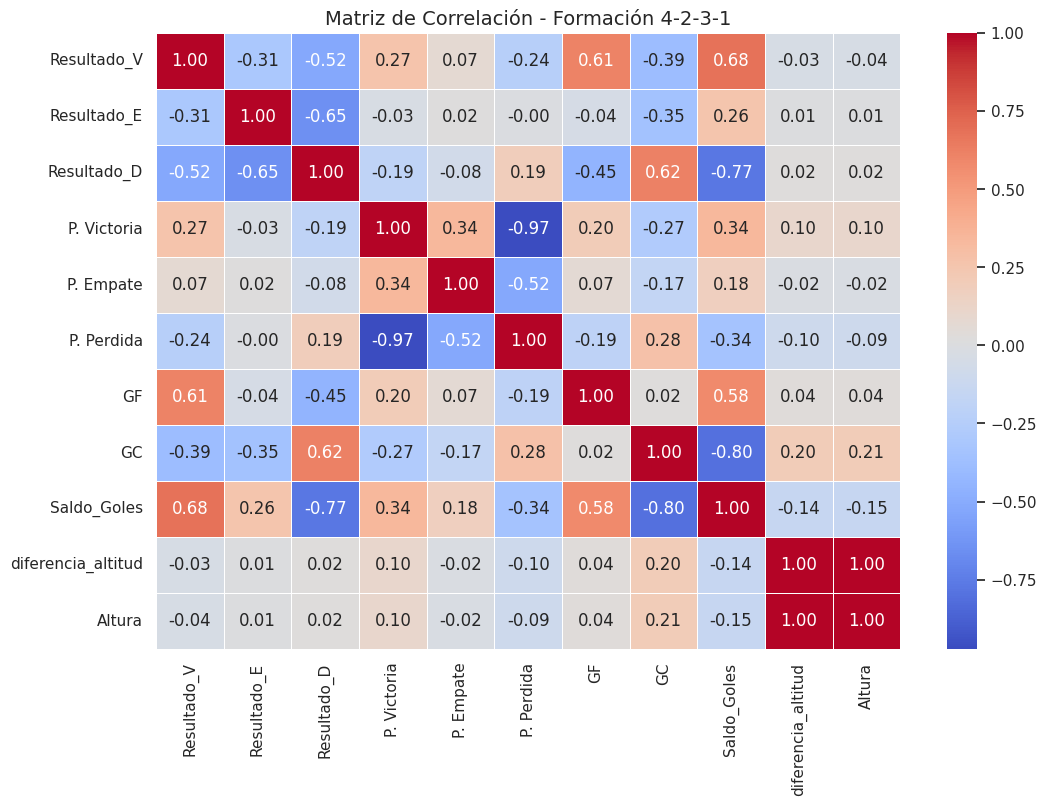

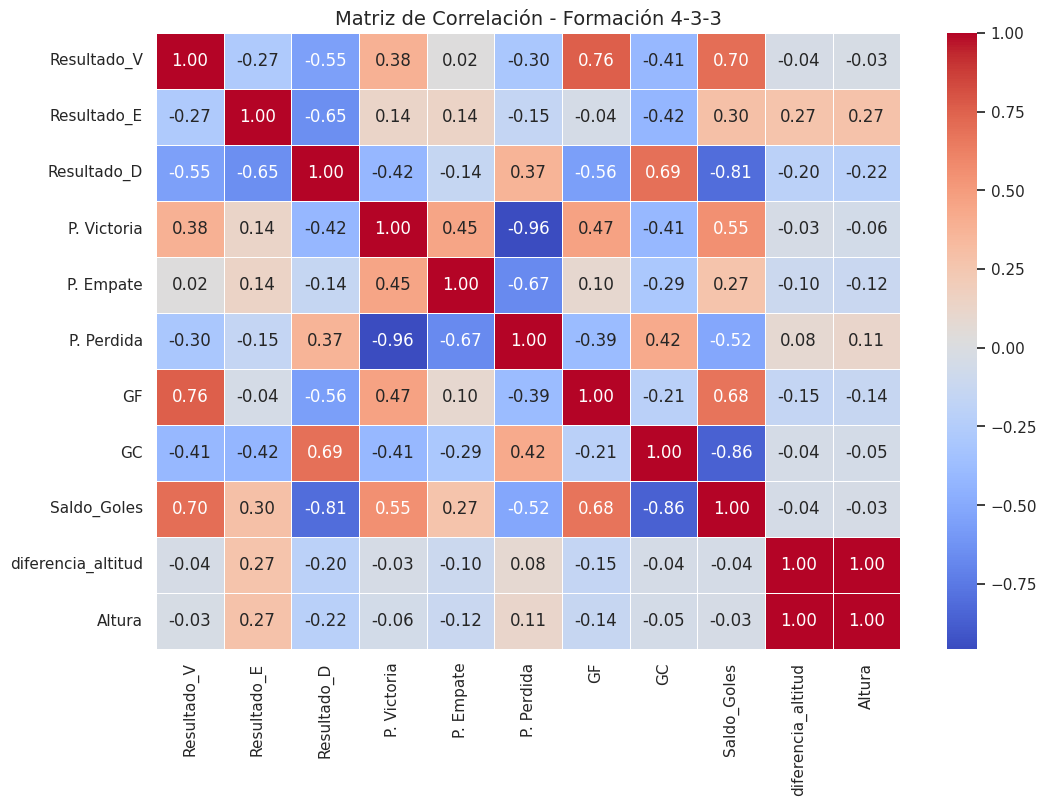

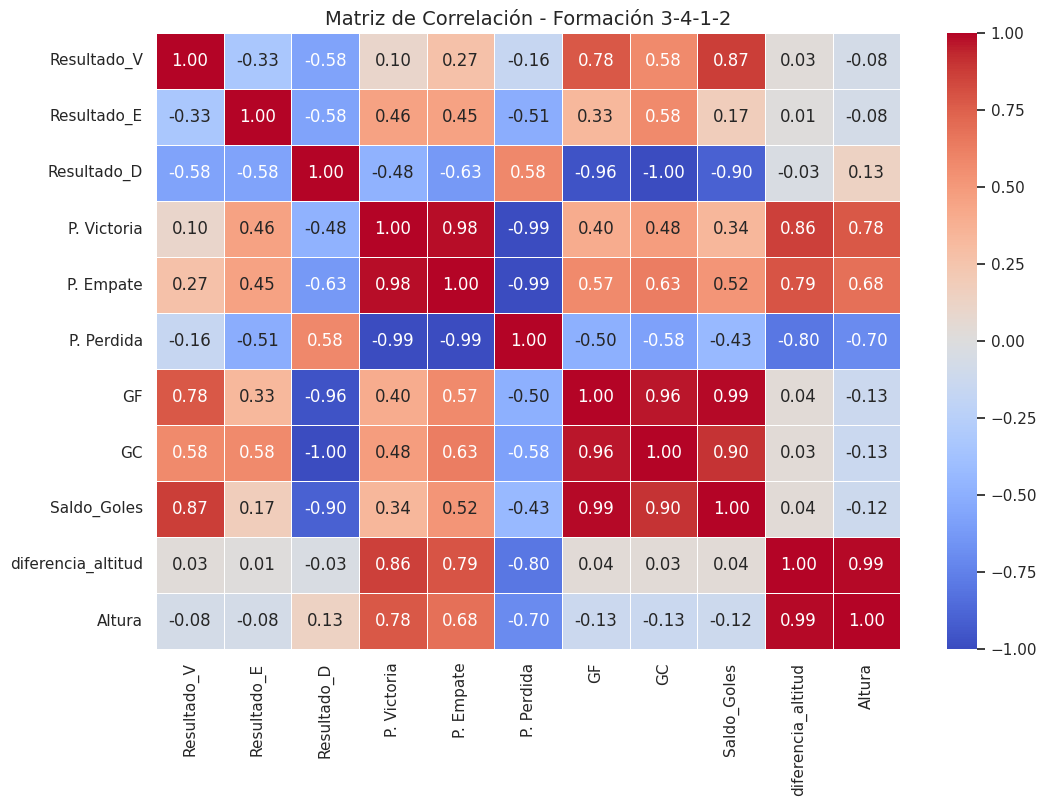

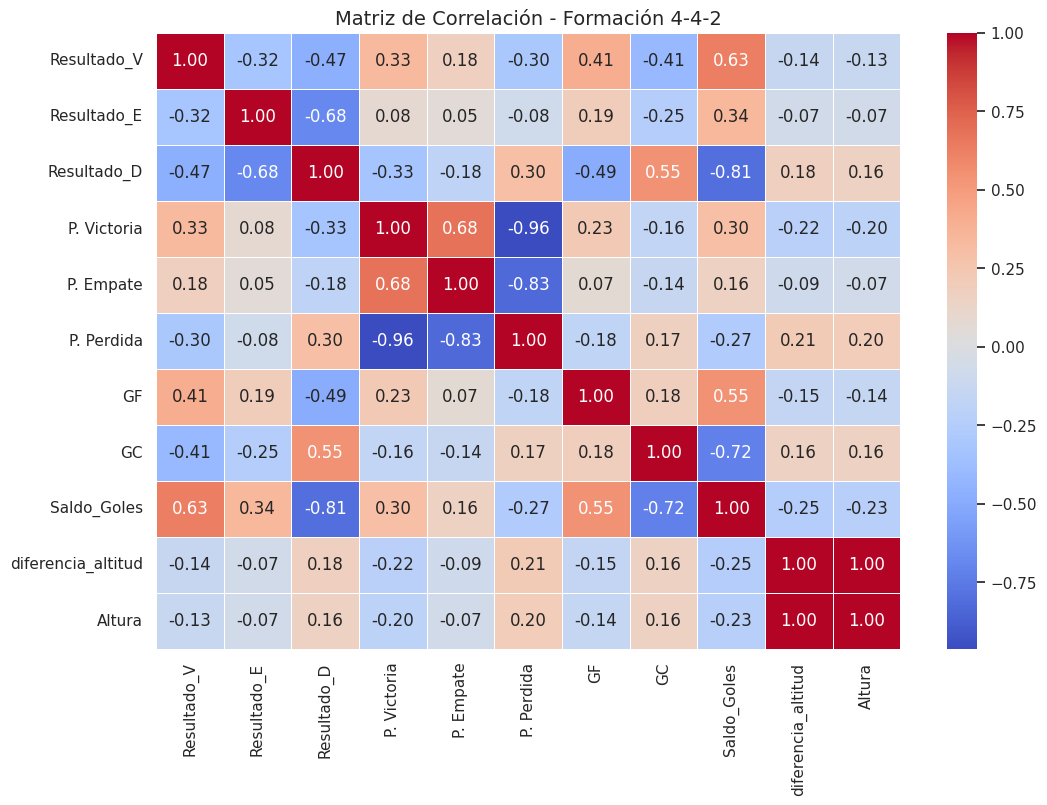

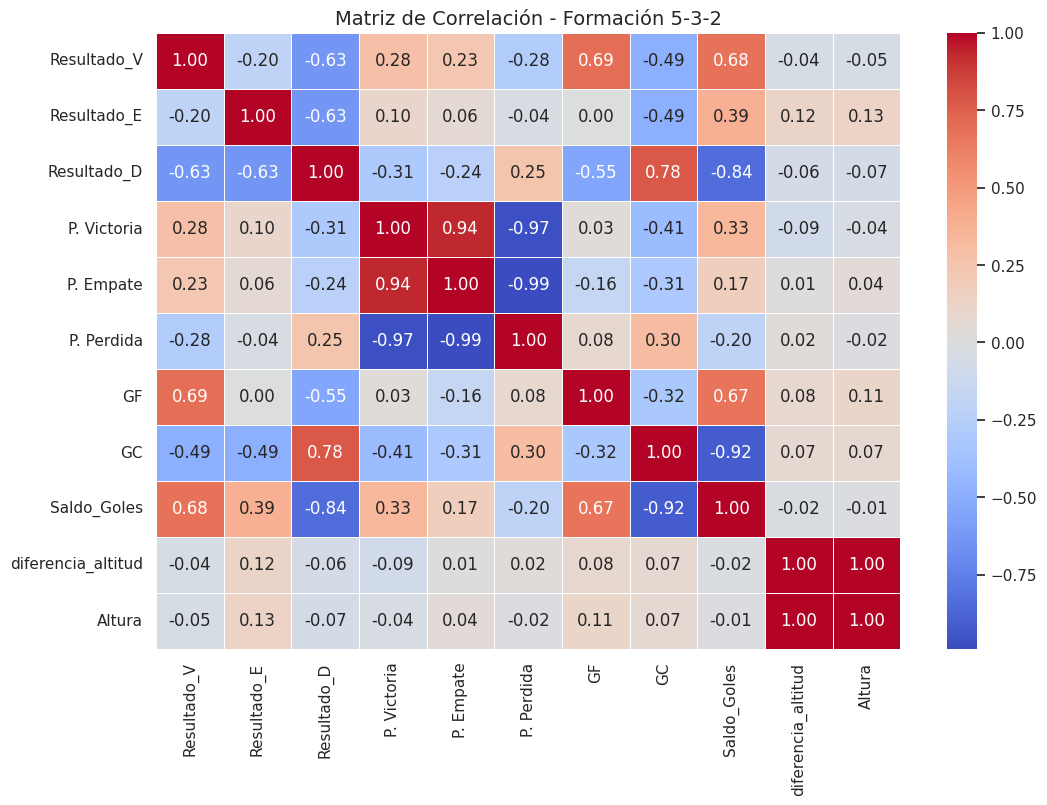

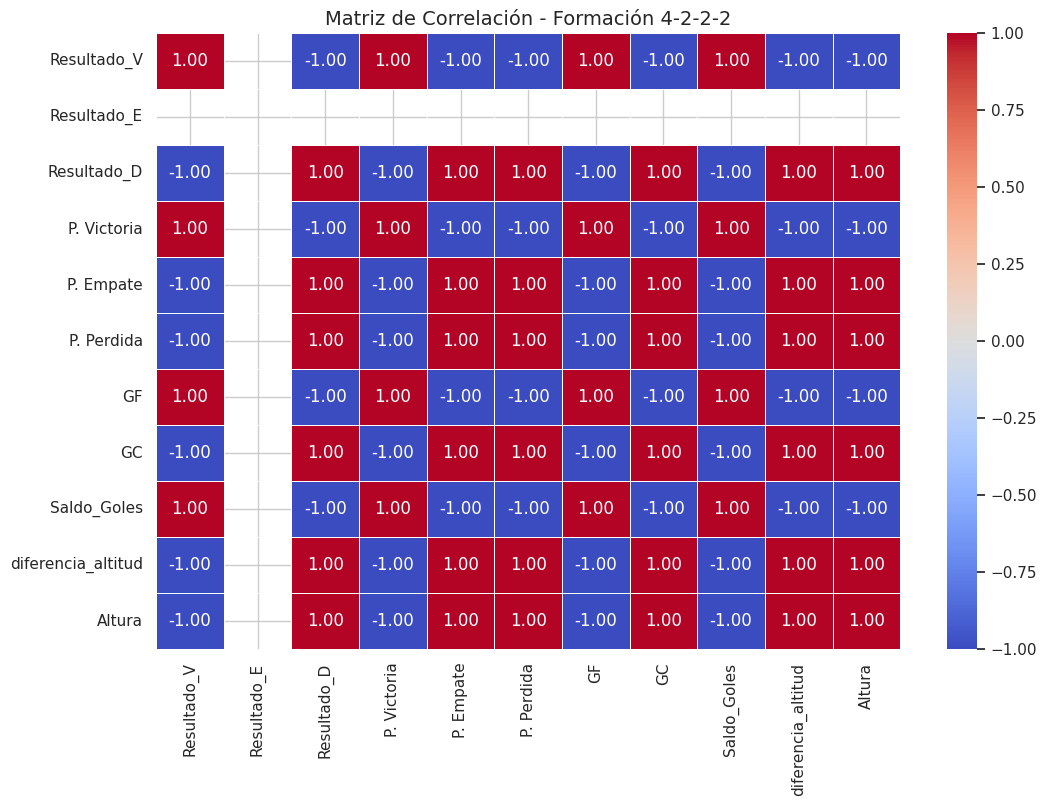

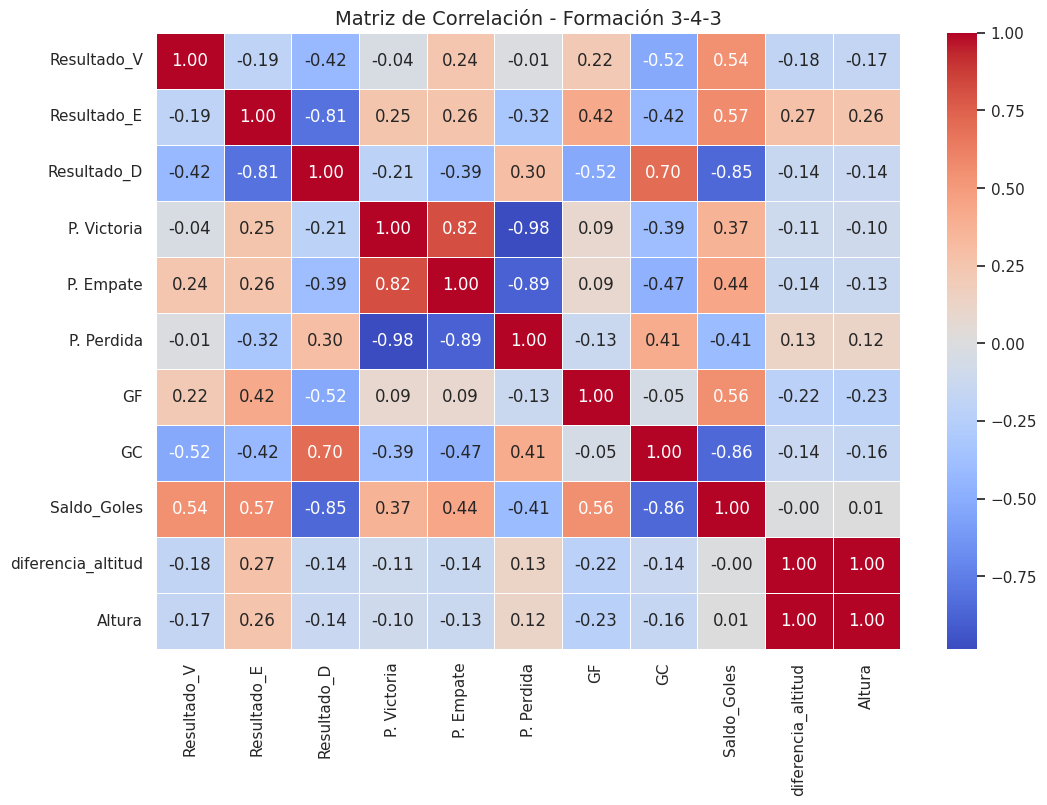

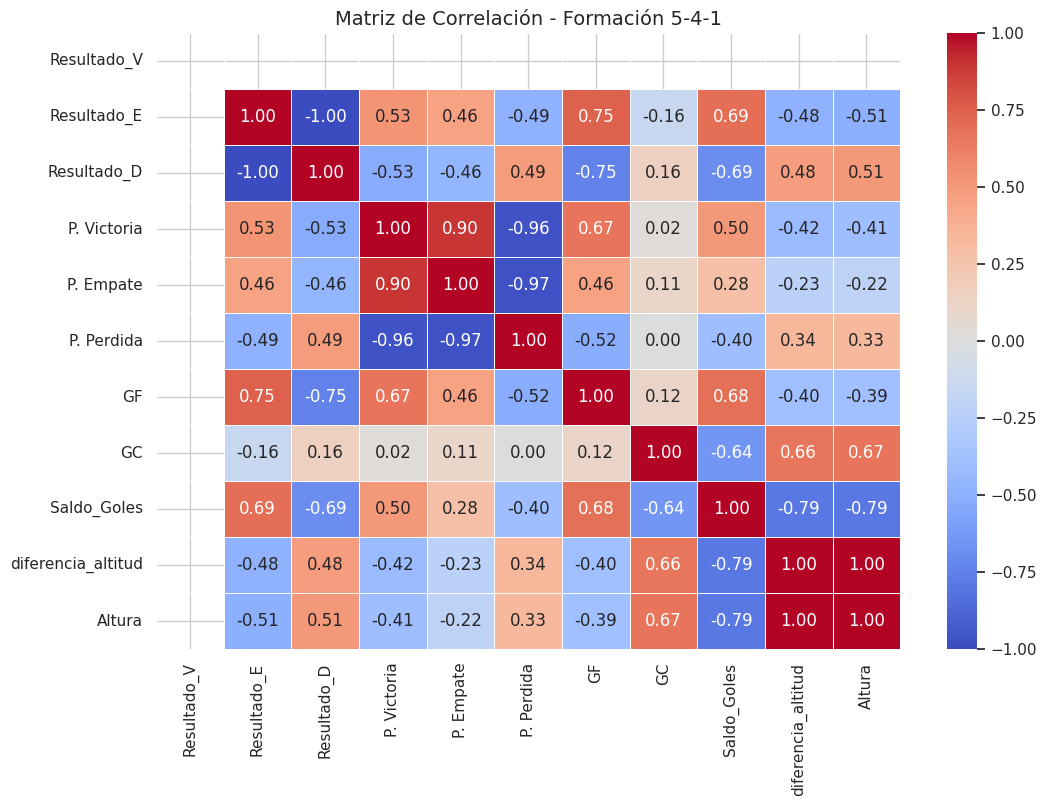

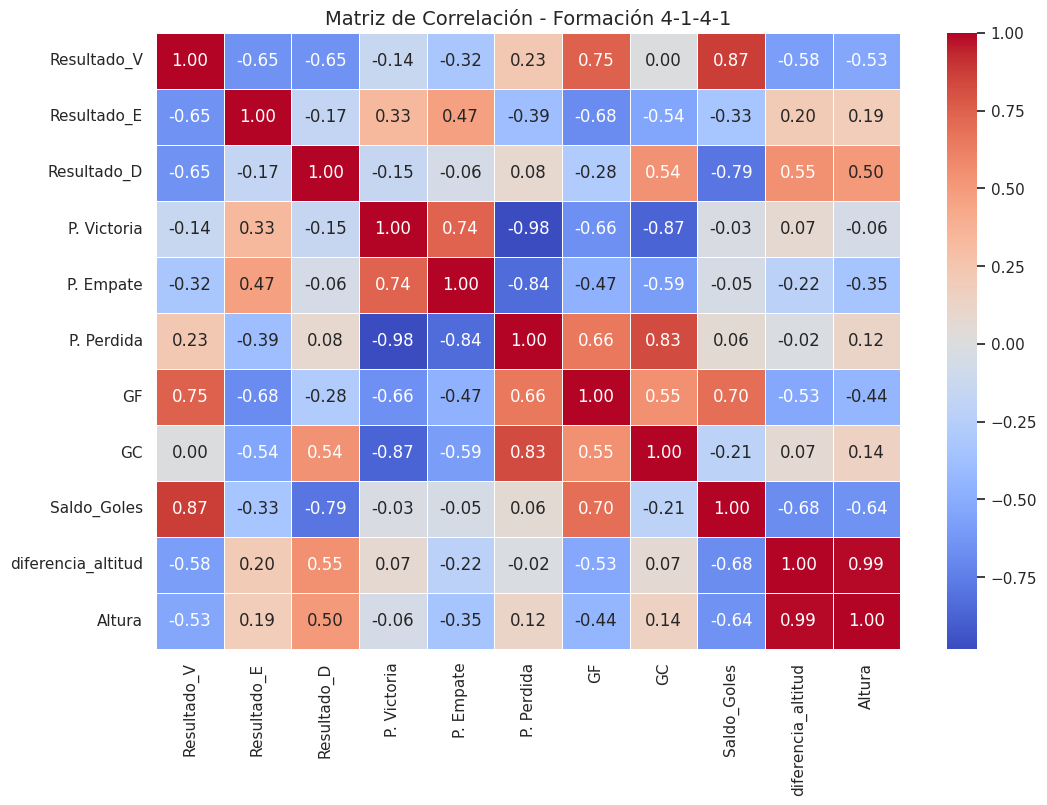

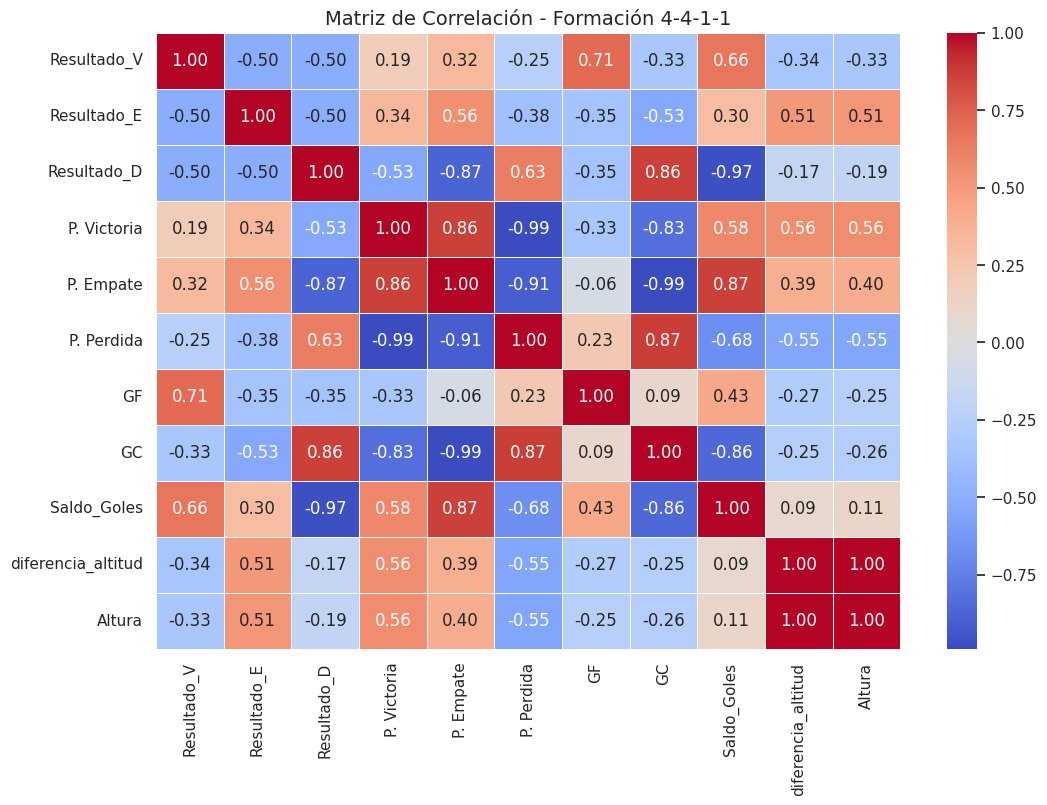

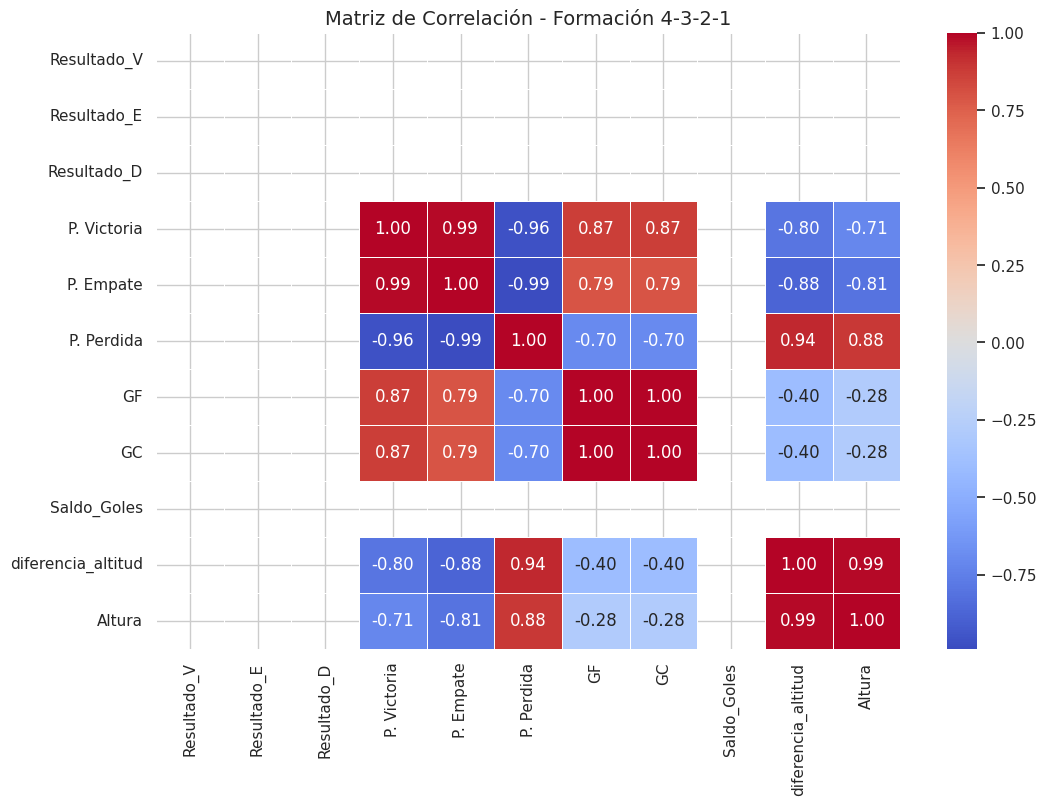

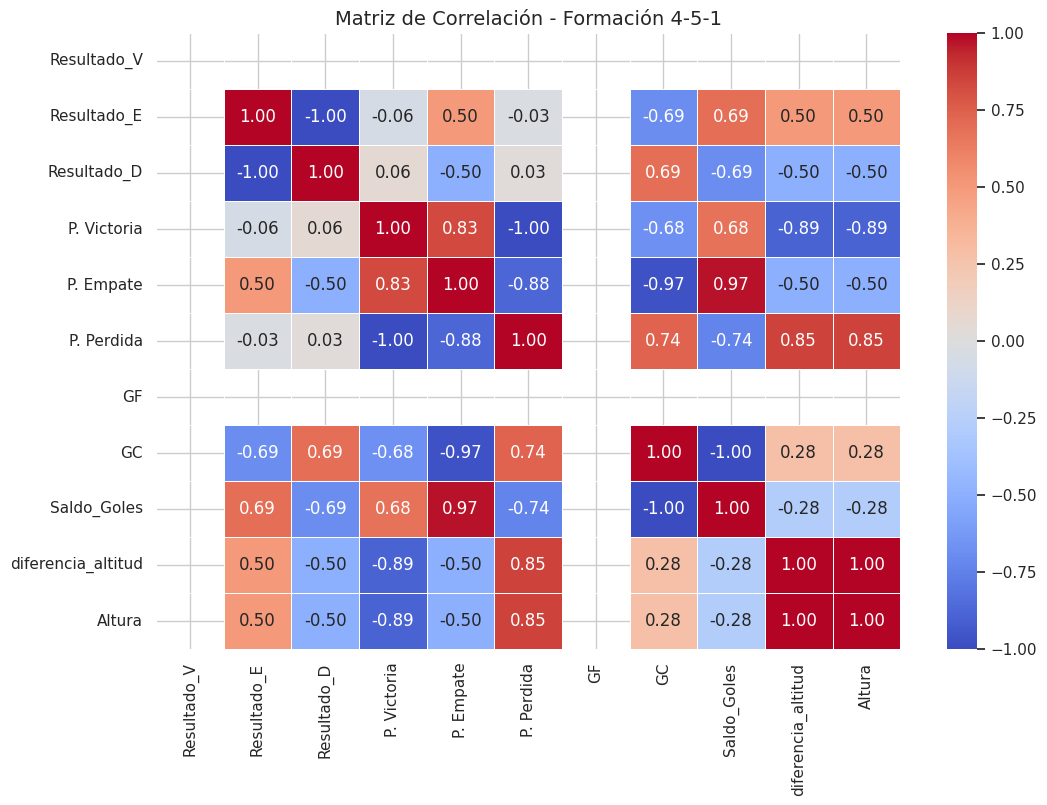

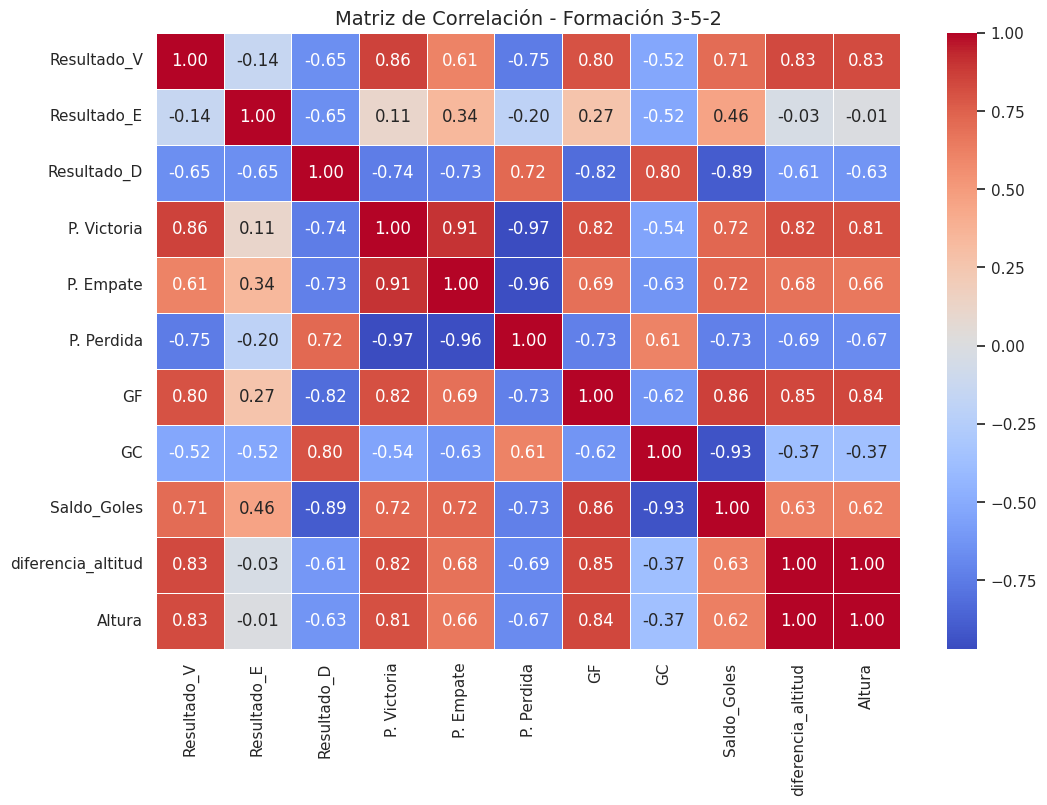

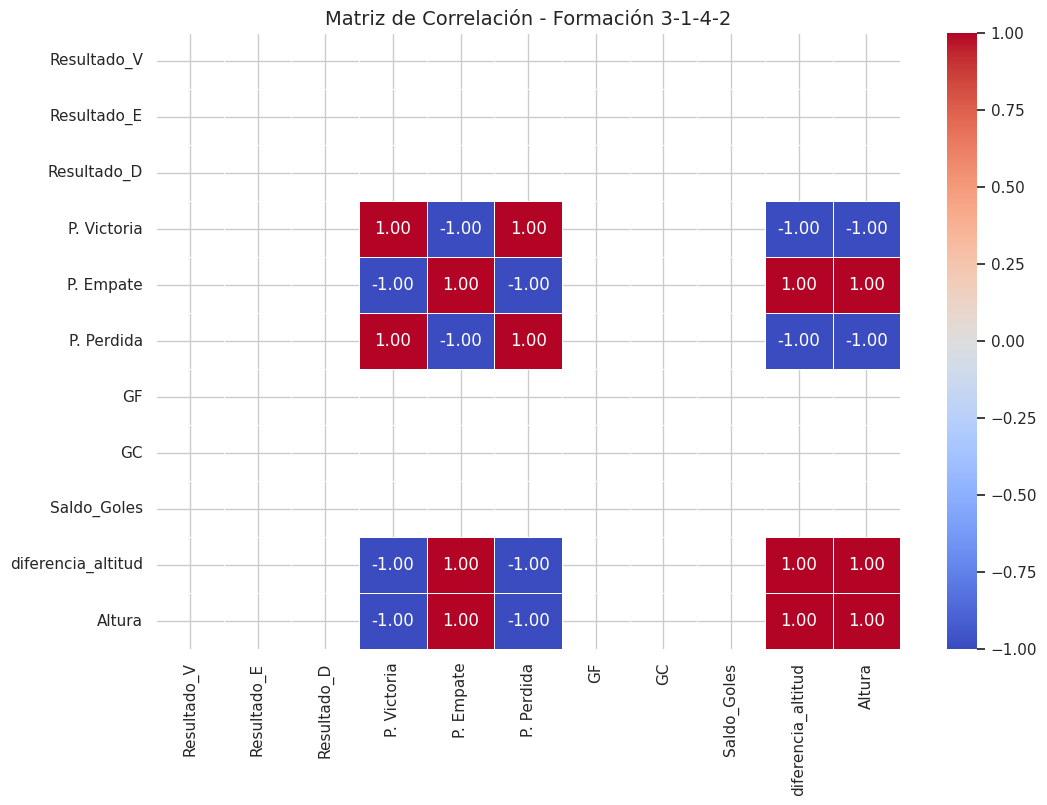

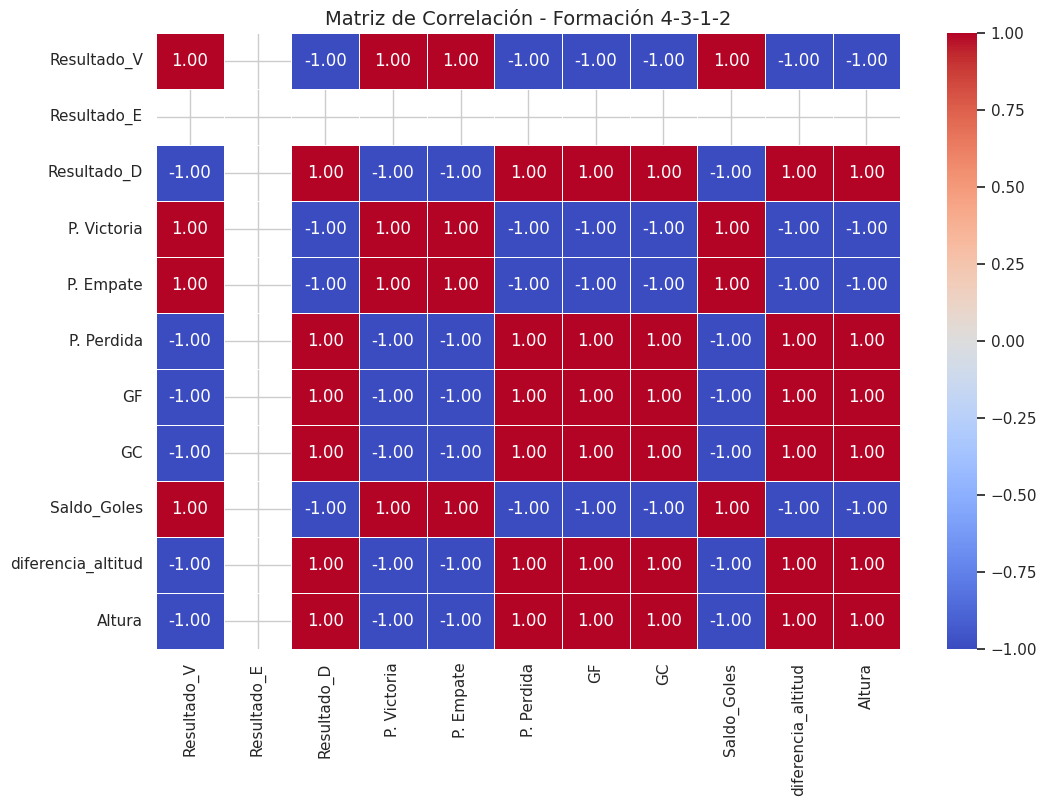

In [35]:
# Lista de formaciones únicas en el DataFrame
formaciones_unicas = df_sierra_costa['Formación Visitante'].unique()

# Iterar sobre las formaciones únicas (limitado a 19)
for i, formacion_evaluar in enumerate(formaciones_unicas[:19]):
    # Filtrar el DataFrame para la formación actual
    df_formaciones = df_sierra_costa[df_sierra_costa['Formación Visitante'] == formacion_evaluar]

    # Seleccionar las columnas relevantes para la correlación
    columnas_relevantes = ['Resultado_V', 'Resultado_E', 'Resultado_D', 'P. Victoria',
                           'P. Empate', 'P. Perdida', "GF", "GC", 'Saldo_Goles',
                           'diferencia_altitud', 'Altura']

    # Verificar si las columnas existen en el DataFrame
    df_corr = df_formaciones[columnas_relevantes].dropna()

    # Calcular la matriz de correlación
    correlation_matrix = df_corr.corr()

    # Crear un mapa de calor con seaborn
    plt.figure(figsize=(12, 8))  # Tamaño del gráfico
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

    # Personalizar el gráfico
    plt.title(f"Matriz de Correlación - Formación {formacion_evaluar}", fontsize=14)

    # Mostrar el gráfico
    plt.show()


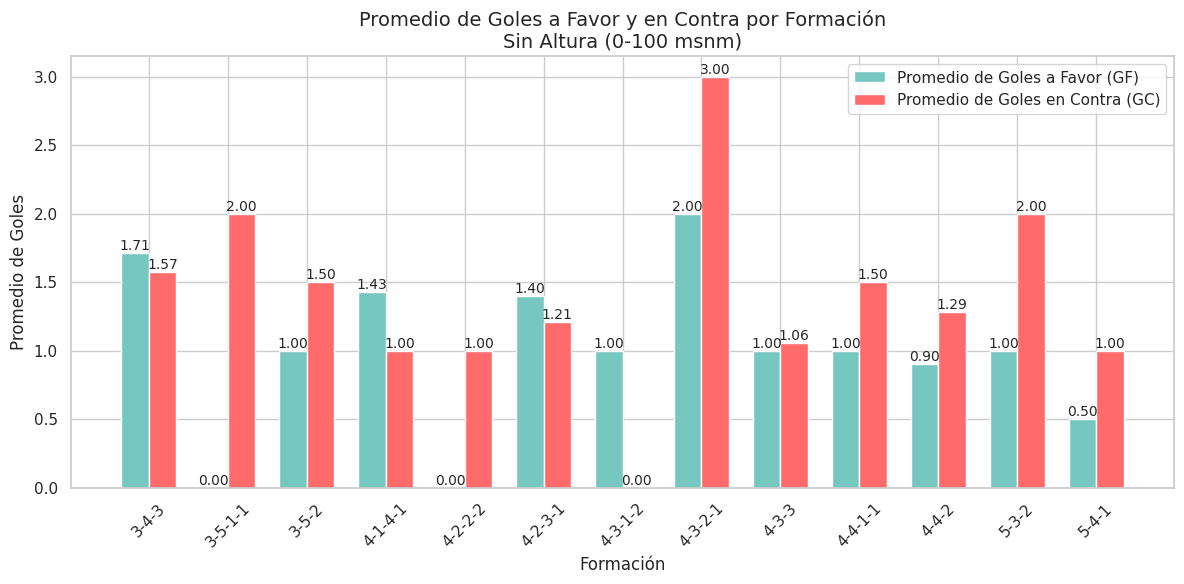

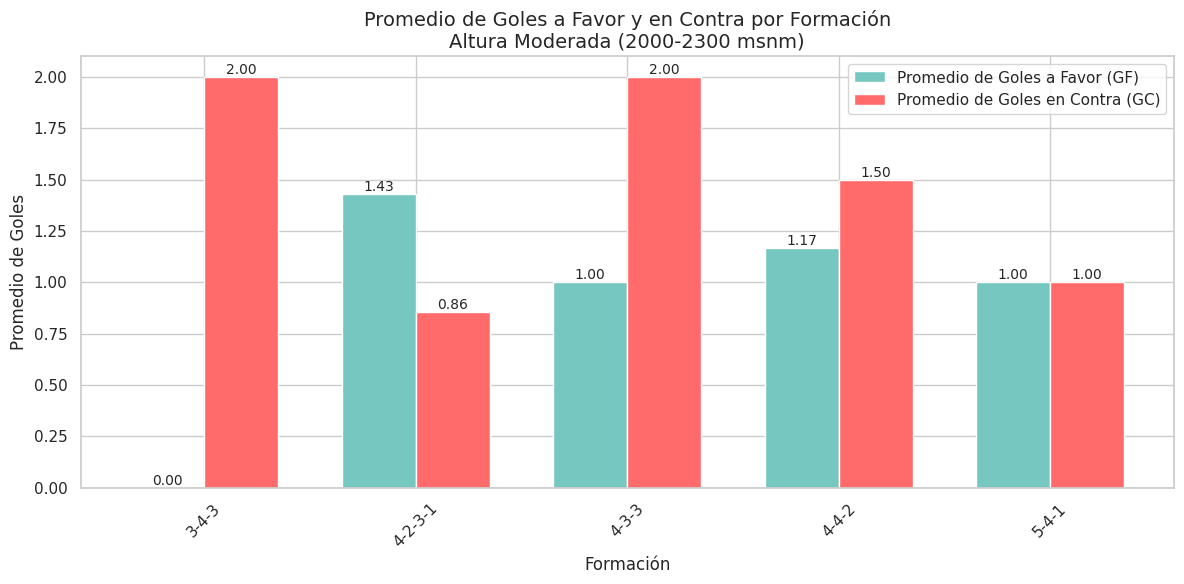

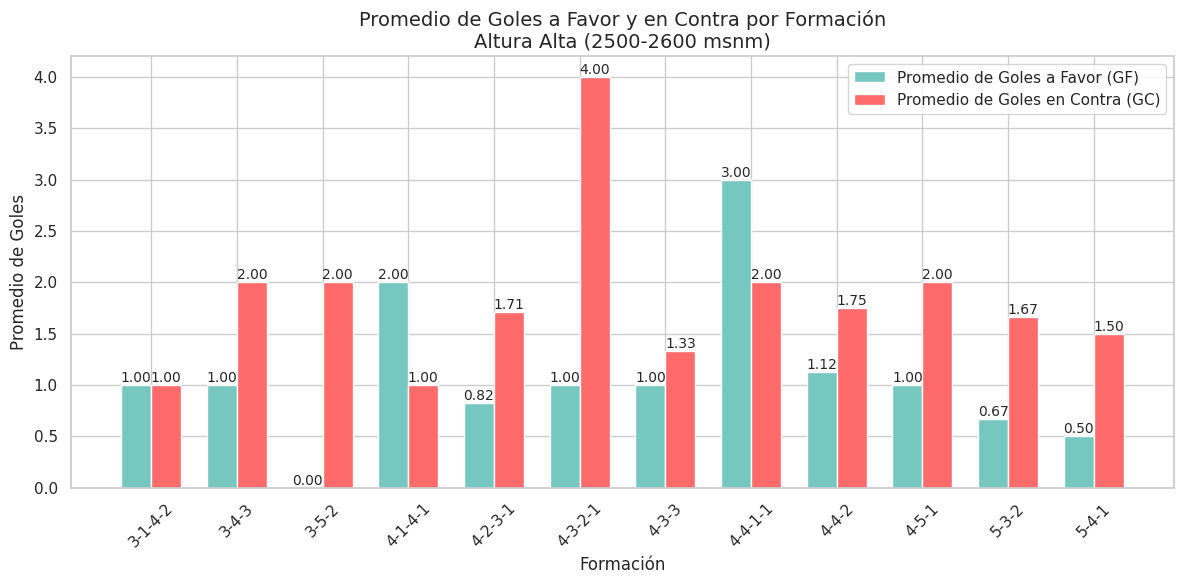

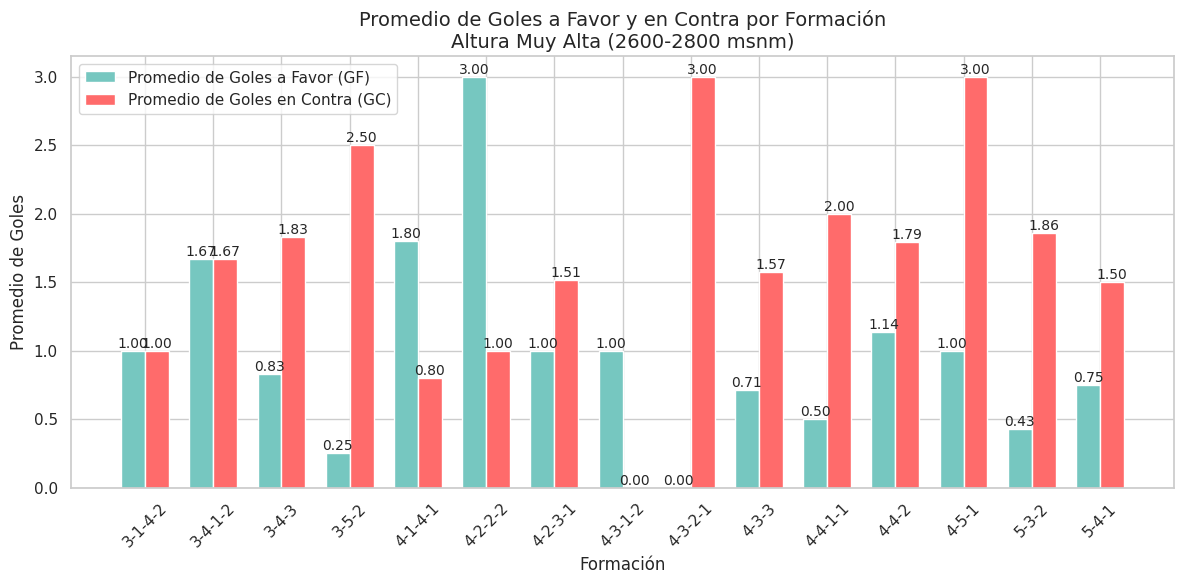

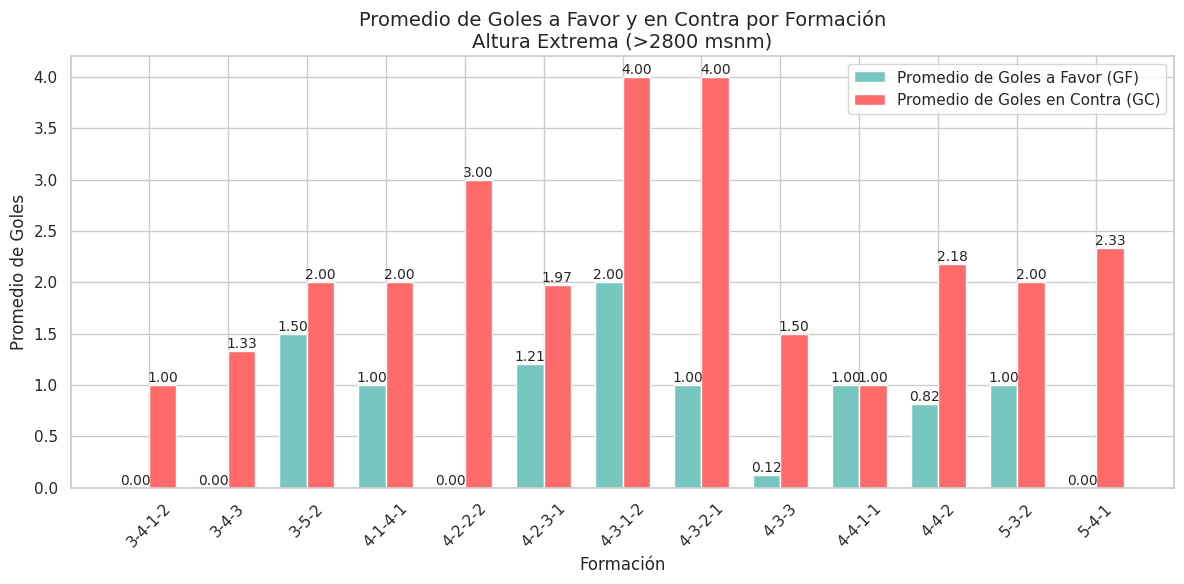

In [36]:
df_sin_altura = df_costa_costa.copy()
df_moderada = df_sierra_costa[(df_sierra_costa["Altura"] > 2000) & (df_sierra_costa["Altura"] <= 2300)]
df_alta = df_sierra_costa[(df_sierra_costa["Altura"] > 2500) & (df_sierra_costa["Altura"] <= 2600)]
df_muy_alta = df_sierra_costa[(df_sierra_costa["Altura"] > 2600) & (df_sierra_costa["Altura"] <= 2800)]
df_extrema = df_sierra_costa[df_sierra_costa["Altura"] > 2800]

# Definir los diferentes DataFrames con sus etiquetas
datasets = {
    "Sin Altura (0-100 msnm)": df_sin_altura,
    "Altura Moderada (2000-2300 msnm)": df_moderada,
    "Altura Alta (2500-2600 msnm)": df_alta,
    "Altura Muy Alta (2600-2800 msnm)": df_muy_alta,
    "Altura Extrema (>2800 msnm)": df_extrema
}

# Función para generar el gráfico de barras para cada DataFrame
def generar_grafico(df, titulo):
    # Verificar que las columnas necesarias existen
    columnas_necesarias = ['Formación Visitante', 'GF', 'GC']
    if not all(col in df.columns for col in columnas_necesarias):
        print(f"El DataFrame para {titulo} no tiene las columnas necesarias. Se omitirá.")
        return

    # Manejo de valores nulos
    #df = df.dropna(subset=['GF', 'GC'])
    #print(df["Visitante"].count())
    # Agrupar por formación y calcular el promedio de GF y GC
    df_grouped = df.groupby('Formación Visitante', as_index=False).agg({
        'GF': 'mean',   # Promedio de goles a favor
        'GC': 'mean'    # Promedio de goles en contra
    })

    # Si no hay datos después de agrupar, omitir
    if df_grouped.empty:
        print(f"No hay suficientes datos para {titulo}. Se omitirá.")
        return

    # Configuración del gráfico
    x = np.arange(len(df_grouped['Formación Visitante']))  # Posiciones en el eje x
    width = 0.35  # Ancho de las barras

    fig, ax = plt.subplots(figsize=(12, 6))

    # Barras agrupadas para GF y GC
    bars1 = ax.bar(x - width/2, df_grouped['GF'], width, label='Promedio de Goles a Favor (GF)', color="#76c7c0")
    bars2 = ax.bar(x + width/2, df_grouped['GC'], width, label='Promedio de Goles en Contra (GC)', color="#ff6b6b")

    # Función para agregar etiquetas sobre las barras
    def agregar_etiquetas(bars):
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}',
                    ha='center', va='bottom', fontsize=10)

    # Añadir etiquetas a cada barra
    agregar_etiquetas(bars1)
    agregar_etiquetas(bars2)

    # Configuración de ejes y leyenda
    ax.set_xlabel('Formación', fontsize=12)
    ax.set_ylabel('Promedio de Goles', fontsize=12)
    ax.set_title(f'Promedio de Goles a Favor y en Contra por Formación\n{titulo}', fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(df_grouped['Formación Visitante'], rotation=45)
    ax.legend()

    # Ajustar el diseño y mostrar el gráfico
    plt.tight_layout()
    plt.show()

# Generar gráficos para cada dataset
for titulo, df in datasets.items():
    generar_grafico(df, titulo)
